# Forecasting the outflow of customers of the Internet provider

The telecom operator wants to learn how to predict the outflow of customers. If it turns out that the user is planning to leave, he will be offered promo codes and special terms of service. The operator's team collected personal data about some customers, information about their tariffs and contracts.

**Data description**

The data consists of files received from different sources:

- 'contract.csv' — information about the contract;
- `personal.csv' — client's personal data;
- `internet.csv' — information about internet services;
- `phone.csv' — information about telephony services.

All files contains the `CustomerID` column - personal code customer.

Information about the contracts is current as of February 1, 2020.

### The purpose of the research

- to build a model that will help the company predict whether its client is going to leave

### Research plan

1. Data overview:
- Loading input data;
- Exploring the data in accordance with the documentation.


2. Data preprocessing:
- Checking for data missing values and hidden duplicates;
- Checking for outliers and suspicious data;
- Checking the correctness of data formats;
- Elimination of identified problems.


3. Data analysis:
- Combining tables by the CustomerID key, taking into account the fact that there are different numbers of IDs in the tables;
- Search and check dependencies between data;
- Feature engineering.


4. Building a model:
- Scaling of numerical features;
- Encoding of categorical data by the OHE method;
- Elimination of class imbalance;
- Selection of the model using cross-validation;
- Testing the model with the necessary condition to achieve the final metric (ROC-AUC >= 0.75).


5. Writing the final report:
- Description of the task, what goals were set;
- Description of the received source data;
- Description of errors and inaccuracies in the data;
- Description of the actions performed with the data;
- Description of the actions performed to write the model;
- Argumentation of final model choice;
- Summary of the work done, recommendations to the customer on further work with the model.

___
### Data Overview
___

Let's make a first look at the data and import all the necessary libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
from datetime import datetime;
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import Image, display

In [3]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
random_state = 80822

Let's read the data files from the /datasets folder and save them in variables:

In [4]:
try:
    df_contract = pd.read_csv('//Users/vladislav/Downloads/final_provider/contract.csv')
    df_personal = pd.read_csv('//Users/vladislav/Downloads/final_provider/personal.csv')
    df_internet = pd.read_csv('//Users/vladislav/Downloads/final_provider/internet.csv')
    df_phone = pd.read_csv('//Users/vladislav/Downloads/final_provider/phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')    

Let's write a function for the primary exploration of datasets:

In [5]:
def describe(df):
    
    display('The first 5 rows of the table', df.head()) 
    display('##############################################')
    display(df.info())
    display('##############################################')
    display('Data description', df.describe(include='all').T)
    display('##############################################')
    display('Number of missing values', df.isna().sum())

We can start exploring the data from the df_contracts (file with users' contracts). According to the data documentation, this table contains information about the terms of contracts:

- BeginDate – start date of using the services,
- EndDate – the end date of using the services,
- Type – payment type: monthly, annual, etc.,
- PaperlessBilling – cashless payment,
- PaymentMethod – payment method,
- MonthlyCharges – monthly expenses for services

In [6]:
describe(df_contract)

'The first 5 rows of the table'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

'##############################################'

'Data description'

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6531,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'##############################################'

'Number of missing values'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [7]:
df_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

According to the information received about the data , it can be noted:
- there are 7043 entries in the table;
- the values in the *CustomerID* column are unique;
- there are only 5 unique values in the *EndDate* column, i.e. there are only 4 unique dates. Probably the operator updated the status of contracts on these dates;
- all columns except *MonthlyCharges* have the object format. For columns with dates and expenses, we will need to change the format;
- there are "No" values in the EndDate column, which means that the contract was valid on February 1, 2020. It is necessary to replace the values with the date of the database formation.

Let's change the format for the start and end of the contract columns:

In [8]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format = '%Y %m %d')
df_contract['BeginDate'].describe(datetime_is_numeric = True)
df_contract['BeginDate'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

By changing the format, it can be seen that for certain clients the contract beginning date was equal to the date of the database formation - *2020-02-01*. Therefore, it can be concluded that they did not have time to use the services of the operator.

Next, for the column with the end date of the contract, we will first replace the value *No* with the database formation date - *2020-02-01*:

In [9]:
df_contract['EndDate'] = df_contract['EndDate'].replace('No', '2020-02-01')

___
**In the future, it will be necessary to take into account that there is an imbalance of classes in the table, since there are no more than a quarter of the entire list of exited clients.**
___

In [10]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format = '%Y %m %d')
df_contract['EndDate'].describe(datetime_is_numeric = True)
#df_contract['EndDate'].describe()

count                             7043
mean     2020-01-11 12:56:19.696152320
min                2019-10-01 00:00:00
25%                2020-01-01 00:00:00
50%                2020-02-01 00:00:00
75%                2020-02-01 00:00:00
max                2020-02-01 00:00:00
Name: EndDate, dtype: object

In [11]:
df_contract.query('BeginDate == "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


If we pay attention to new customers who have just connected to the operator, we will notice that they have indicated only the cost of the tariff in *MonthlyCharges*, and they have not yet had time to incur total expenses and the values in the column *TotalCharges* are missing. It is better to replace them with 0, then in the future there will be no difficulties with transforming this column into numerical data format.

In [12]:
df_contract.loc[(df_contract['BeginDate'] == "2020-02-01"), 'TotalCharges'] = 0

In [13]:
df_contract['TotalCharges']= pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

This way necessary actions were taken to change the format of the data in this table. We can check that all rows in the *TotalCharges* column have changed without errors:

In [14]:
df_contract['TotalCharges'].isna().sum()

0

To check, we can also calculate whether there was a negative difference between total and monthly costs:

In [15]:
df_contract['ChargesDelta'] = df_contract['TotalCharges'] - df_contract['MonthlyCharges']
df_contract.query('ChargesDelta < 0')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChargesDelta
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,-52.55
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,-20.25
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,-80.85
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,-25.75
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,-56.05
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,-19.85
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,-25.35
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,-20.00
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,-19.70
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,-73.35


It can be seen that negative values are typical only for customers who have just connected by February 2020. Therefore there are no suspicious values in the cost columns. The column can be deleted.

In [16]:
df_contract = df_contract.drop('ChargesDelta', axis=1)

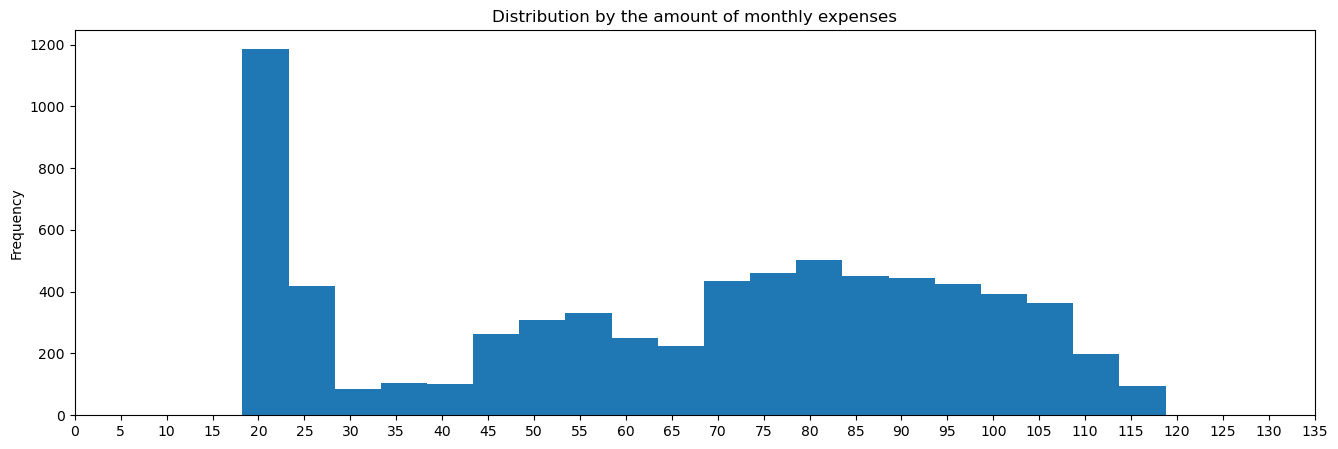

In [17]:
df_contract['MonthlyCharges'].plot(kind='hist', figsize = (16,5), xticks=np.arange(0,140,5), bins = 20)
plt.title('Distribution by the amount of monthly expenses')
plt.show()

According to the volume of monthly expenses, it is clear that the majority of customers used the minimum set of services.

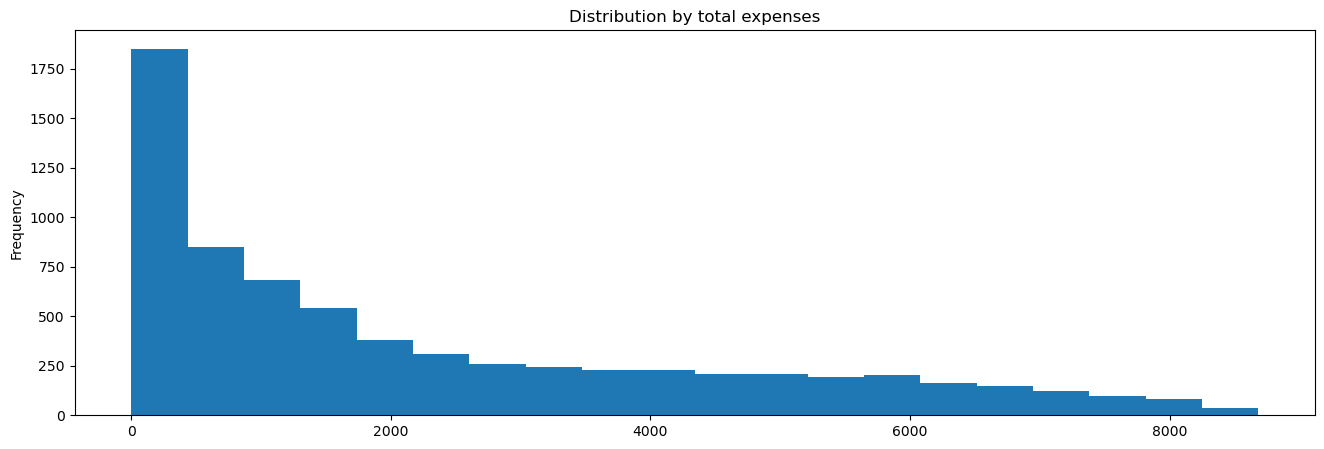

In [18]:
df_contract['TotalCharges'].plot(kind='hist', figsize = (16,5), bins = 20)
plt.title('Distribution by total expenses')
plt.show()

In [19]:
df_contract.query('TotalCharges < 50')['BeginDate'].value_counts()

2020-01-01    175
2019-12-01     78
2019-11-01     50
2019-09-01     31
2019-10-01     30
2020-02-01     11
2019-08-01      1
Name: BeginDate, dtype: int64

A significant share of the minimum costs for the entire period is explained by the large number of new customers who joined 1-2 months before the database formation date.

In [20]:
df_contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [21]:
df_contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [22]:
df_contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

No errors or hidden duplicates were found in the columns *Type*, *PaperlessBilling* and *PaymentMethod*. We can proceed to the research analysis of the following table.
___

Next, let's study the personal (df_personal) database. According to the data documentation, this database contains information about the personal data of customers:

- Dependents – having dependents
- Senior Citizen – having retirement status by age
- Partner – the presence of a spouse(s)

In [23]:
describe(df_personal)

'The first 5 rows of the table'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

'##############################################'

'Data description'

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'##############################################'

'Number of missing values'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [24]:
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [25]:
df_personal['SeniorCitizen'].unique()

array([0, 1])

In [26]:
df_personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [27]:
df_personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

According to the information gained about the data , it can be noted:
- there are 7043 unique rows in the table, which corresponds to the number of unique contracts;
- there are no missing values and hidden duplicates in the data;
- all columns contain data with categorical variables, some of them will need to be encoded to train the model.

We can proceed to the research analysis of the following table.
___

Next, let's study the internet(df_internet) database. From the data documentation It is known :

- Connection can be either via a telephone line (DSL) or fiber optic cable (*Fiber optic*).

The following services are also available:

- Internet security: antivirus (*DeviceProtection*) and blocking unsafe sites (*OnlineSecurity*);
- Dedicated technical support line (*TechSupport*);
- Cloud file storage for data backup (*OnlineBackup*);
- Streaming television (*StreamingTV*) and movie catalog (*StreamingMovies*).

In [28]:
describe(df_internet)

'The first 5 rows of the table'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

'##############################################'

'Data description'

,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


'##############################################'

'Number of missing values'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

According to the information gained about the data , it can be noted:
- there are 5517 unique rows in the table, which means that not all customers used Internet services;
- there are no missing values and hidden duplicates in the data;
- all columns contain data with categorical variables, some of them will need to be encoded to train the model.

You can proceed to the research analysis of the following table.
___

Next, let's study the phone(df_phone) database. From the data documentation it is known :

- Multiplelines-the possibility of maintaining parallel lines during a call

In [29]:
describe(df_phone)

'The first 5 rows of the table'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


'##############################################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

'##############################################'

'Data description'

,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


'##############################################'

'Number of missing values'

customerID       0
MultipleLines    0
dtype: int64

According to the information gained about the data , it can be noted:
- there is a unique entry in table 6361, which means that not all customers used telephone services;
- there are no missing values and hidden duplicates in the data;
- all columns contain data with categorical variables, some of them will need to be encoded to train the model.

At this stage, the initial data analysis is completed.
___

___
### Data Analysis
___

Now data from different tables can be joined. In the 'how' parameter, we need to set the value 'outer' so that no one line would lost. Since their number is different in different tables.

In [30]:
merged = pd.merge(df_contract, df_personal, on='customerID', how='outer')
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No


In [31]:
merged.shape

(7043, 12)

In [32]:
df_internet.shape

(5517, 8)

In [33]:
merged = pd.merge(merged, df_internet, on='customerID', how='outer')
merged.shape

(7043, 19)

In [34]:
merged.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1474,9495-SKLKD,2016-05-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),95.95,4456.65,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes
1192,1579-KLYDT,2019-03-01,2019-10-01,Month-to-month,Yes,Electronic check,90.45,593.45,Male,0,No,No,Fiber optic,No,No,Yes,No,Yes,No
256,7017-VFHAY,2015-01-01,2020-02-01,Two year,No,Credit card (automatic),115.10,7008.15,Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
7000,0052-YNYOT,2014-07-01,2020-02-01,One year,No,Electronic check,20.55,1343.40,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2321,9776-OJUZI,2014-09-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),95.45,6223.30,Female,1,No,No,Fiber optic,No,Yes,Yes,No,Yes,No


In [35]:
df_phone.shape

(6361, 2)

In [36]:
merged = pd.merge(merged, df_phone, on='customerID', how='outer')
merged.shape

(7043, 20)

In [37]:
merged.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
6010,3460-TJBWI,2018-02-01,2020-02-01,Two year,No,Mailed check,24.20,609.05,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3211,4359-INNWN,2018-09-01,2020-02-01,One year,No,Credit card (automatic),20.05,337.90,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3706,4993-JCRGJ,2017-12-01,2020-02-01,Month-to-month,Yes,Mailed check,84.30,2281.60,Male,0,No,No,Fiber optic,No,No,Yes,Yes,No,No,Yes
4149,6559-ILWKJ,2014-02-01,2020-01-01,Two year,No,Electronic check,49.35,3515.25,Male,0,Yes,No,DSL,No,Yes,No,No,Yes,Yes,NaN
5485,7794-JASDG,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,50.75,50.75,Male,0,No,No,DSL,Yes,No,No,No,No,No,No


In [38]:
merged.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2123,8819-IMISP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,80.45,2429.10,Male,0,No,No,Fiber optic,No,Yes,No,No,No,No,Yes
6840,1724-IQWNM,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,19.30,19.30,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1365,7721-JXEAW,2014-12-01,2019-11-01,Month-to-month,Yes,Bank transfer (automatic),41.05,2452.70,Male,0,Yes,No,DSL,No,Yes,No,No,No,Yes,NaN
3279,6064-PUPMC,2018-03-01,2020-02-01,One year,No,Credit card (automatic),57.20,1423.35,Male,0,Yes,Yes,DSL,Yes,No,No,Yes,No,No,No
827,9146-JRIOX,2018-12-01,2020-02-01,Month-to-month,No,Mailed check,25.55,372.45,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes


Now let's determine if there were CustomerIDs in *df_internet* and *df_phone CustomerID* tables that were not in the *df_contract and df_personal* tables. In this case, *Nan* should appear in *df_contract and df_personal*.

In [39]:
for i in ('Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
          'SeniorCitizen', 'Partner', 'Dependents'):
    print(merged[i].isna().sum())

0
0
0
0
0
0
0
0
0


There are no Nan values in the checked columns, which means that df_contract and df_personal had all the unique clients, but some of them did not use Internet or telephone services from the operator.
Therefore, the Nan values in the columns for Internet services and the *MultipleLines* column (in fact, in the entire table) can be replaced with No, which does not contradict with the logic used.

In [40]:
merged = merged.fillna('No')
merged.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

The *BeginDate* and *EndDate* columns will subsequently allow us to generate Target values for the model. And, most likely, they will lead to data leakage, so they will have to be deleted. In this case, we can use the difference between the dates as one of the features.

In [41]:
merged['contractPeriod'] = (merged['EndDate'] - merged['BeginDate']).dt.days

In [42]:
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61


Let's create a Target variable:

In [43]:
def target (EndDate):
    if EndDate != datetime(2020, 2, 1):
        return 1
    else:
        return 0

In [44]:
merged['Target'] = merged.apply(lambda x: target(x.EndDate), axis=1)

In [45]:
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


In [46]:
merged = merged.drop(['BeginDate', 'EndDate'], axis=1)

In [47]:
merged.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


The *CustomerID* column appears to be randomly generated and is unique for each customer, including future customers. Therefore, it cannot have influence to target attribute. It can be deleted.

In [48]:
merged = merged.drop('customerID', axis=1)
merged.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


Let's create a tool for encoding categorical features:

In [49]:
encoder = OrdinalEncoder()
merged_ordinal = merged
merged_ordinal[['Type','PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner',
               'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'MultipleLines']] = encoder.fit_transform(merged_ordinal[['Type',
                                                                      'PaperlessBilling',
                                                                      'PaymentMethod', 'gender',
                                                                      'SeniorCitizen', 'Partner',
               'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'MultipleLines']])
merged_ordinal.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractPeriod,Target
0,0.0,1.0,2.0,29.85,29.85,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31,0
1,1.0,0.0,3.0,56.95,1889.50,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1036,0
2,0.0,1.0,3.0,53.85,108.15,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,61,1
3,1.0,0.0,0.0,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1371,0
4,0.0,1.0,2.0,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61,1


Next, it makes sense to study the dependence of features on each other.

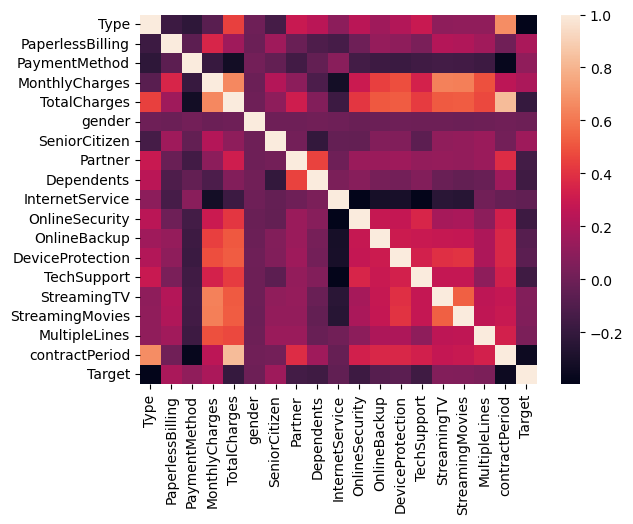

In [50]:
corr = merged_ordinal.corr()
sns.heatmap(corr)
plt.show()

It can be seen here that the columns with numerical data *contractPeriod* and *TotalCharges* have the least correlation with the target variable. We can keep this in mind at the stage of studying the importance of parameters for models.

It can also be seen that the services *OnlineBackup*, *DeviceProtection*, *TechSupport*, *StreamingTV*, *StreamingMovies* and *MultipleLines* were not provided by the operator for free and affected the indicators of monthly and total expenses of customers.

### Building a model

For more convenient building of model, we will write functions:

In [51]:
def make_features_target (data, target_col='Target'):
    features = data.drop(target_col, axis=1)
    target = data[target_col]
    return features, target

In [52]:
def split_data (features, target):
    features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                                test_size=0.2,
                                                                                random_state = random_state)
    scaler = StandardScaler()
    numeric = ['MonthlyCharges', 'TotalCharges', 'contractPeriod']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_test, target_train, target_test

Let's divide the dataset into samples:

In [53]:
pd.options.mode.chained_assignment = None

In [54]:
features, target = make_features_target(merged_ordinal)
features_train, features_test, target_train, target_test = split_data(features, target)

#### LogisticRegression

For logistic regression, it is necessary to examine the data for the presence of multicollinearity:

In [55]:
vif_scores = pd.DataFrame()
vif_scores['Atrribute'] = features.columns

vif_scores['VIF scores'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
display(vif_scores)

,Atrribute,VIF scores
0,Type,4.078135
1,PaperlessBilling,2.874230
2,PaymentMethod,2.970294
3,MonthlyCharges,16.166061
4,TotalCharges,14.297280
5,gender,1.947504
6,SeniorCitizen,1.361945
7,Partner,2.819666
8,Dependents,1.955419
9,InternetService,3.367112


The columns *MonthlyCharges*, *TotalCharges*, *contractPeriod* shows high value and must be deleted to eliminate multicollinearity.

In [56]:
features_lr = features.drop(['contractPeriod', 'MonthlyCharges', 'TotalCharges'], axis=1)

In [57]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target,
                                                                                       test_size = 0.2,
                                                                                       random_state = random_state)

In [58]:
lr_CV = LogisticRegressionCV(cv = 10, scoring = 'roc_auc', n_jobs = -1)
lr_CV.fit(features_train_lr, target_train_lr)

probabilities_lrCV_test = lr_CV.predict_proba(features_test_lr)
probabilities_lrCV_one_test = probabilities_lrCV_test[:,1]

roc_auc_score(target_test_lr, probabilities_lrCV_one_test)

0.8120417201378929

**The auc-roc value obtained using Logistic Regression was 0.81, it can be taken into account as a baseline.**

#### RandomForestClassifier

In [59]:
rfc = RandomForestClassifier(class_weight = 'balanced', n_estimators = 30, max_depth = 6,
                               random_state = random_state)

parameters = {'n_estimators': [10, 100, 200],
             'max_depth': [2, 6, 8],
             'max_features': [2, 6, 12]}

Grid_rfc = GridSearchCV(estimator = rfc, param_grid = parameters, scoring = 'roc_auc', cv = 5, refit=True)
rf_result = Grid_rfc.fit(features_train, target_train)

print("\n Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_rfc.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_rfc.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_rfc.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=12,
                       n_estimators=200, random_state=80822)

 The best score across ALL searched params:
 0.8665386315765684

 The best parameters across ALL searched params:
 {'max_depth': 8, 'max_features': 12, 'n_estimators': 200}


In [60]:
rfc_model = RandomForestClassifier(**Grid_rfc.best_params_)
rfc_model.fit(features_train, target_train)
probabilities_rfc_test = rfc_model.predict_proba(features_test)
rfc_model_one_test = probabilities_rfc_test[:,1]

rfc_roc_auc = roc_auc_score(target_test, rfc_model_one_test)
print(rfc_roc_auc)

0.8717093178329685


The random forest showed a higher auc-roc value without taking into account the evaluation of the importance of the parameters. Let's make such an assessment and see how the required indicator changes:

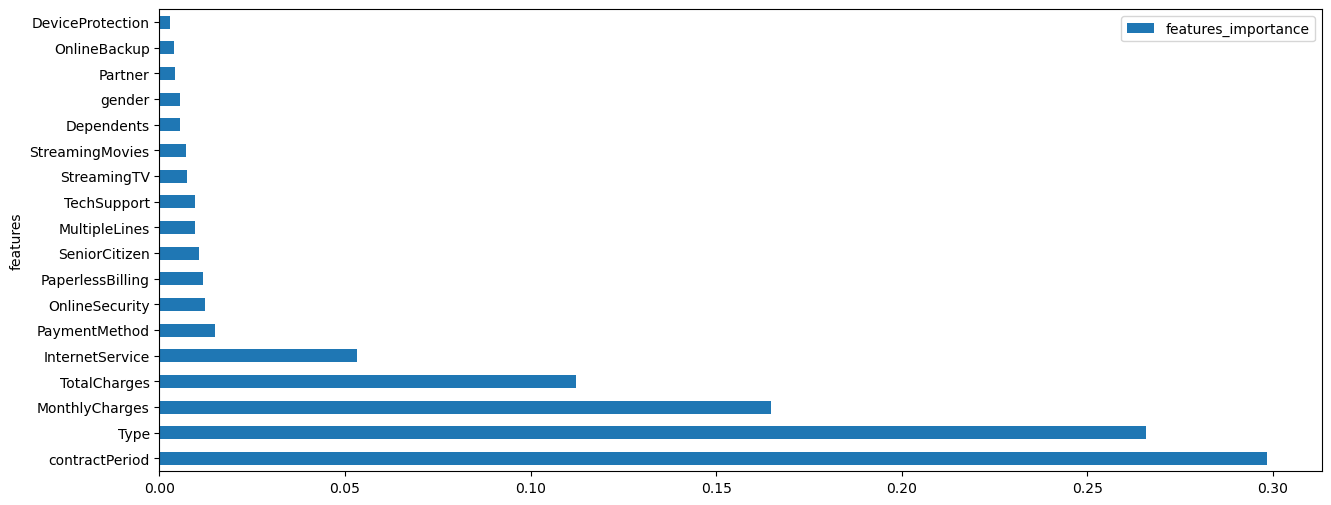

In [61]:
rfc_feature_importances = pd.DataFrame({'features':features_train.columns,
                                   'features_importance':rfc_model.feature_importances_}).sort_values(
    'features_importance', ascending=False)
rfc_feature_importances.set_index('features').plot(kind='barh', figsize=(15,6))
plt.show()

Therefore, we can see that the columns *contractPeriod*, *Type*, *MonthlyCharges*, *TotalCharges*, *InternetService* have the greatest impact.
Let's try to remove the remaining columns and retrain the model.

In [62]:
rfc_features = features.drop(['DeviceProtection', 'Partner', 'OnlineBackup',
                              'gender', 'Dependents', 'StreamingMovies', 'StreamingTV',
                             'MultipleLines', 'TechSupport', 'SeniorCitizen', 'PaperlessBilling',
                                 'OnlineSecurity', 'PaymentMethod'], axis = 1) 
rfc_features_train, rfc_features_test, rfc_target_train, rfc_target_test = split_data(rfc_features, target)

In [63]:
rfc_fi = RandomForestClassifier(class_weight = 'balanced', n_estimators = 30, max_depth = 6,
                               random_state = random_state)

parameters = {'n_estimators': [10, 100, 200],
             'max_depth': [2, 6, 8],
             'max_features': [0.1, 0.25, 0.5]}

Grid_rfc_fi = GridSearchCV(estimator = rfc_fi, param_grid = parameters, scoring = 'roc_auc', cv = 5, refit=True)
rf_result_fi = Grid_rfc_fi.fit(rfc_features_train, rfc_target_train)

print("\n Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_rfc_fi.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_rfc_fi.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_rfc_fi.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.5,
                       random_state=80822)

 The best score across ALL searched params:
 0.8631877741413934

 The best parameters across ALL searched params:
 {'max_depth': 8, 'max_features': 0.5, 'n_estimators': 100}


In [64]:
rfc_model_fi = RandomForestClassifier(**Grid_rfc_fi.best_params_)
rfc_model_fi.fit(rfc_features_train, rfc_target_train)
probabilities_rfc_test_fi = rfc_model_fi.predict_proba(rfc_features_test)
rfc_model_one_test_fi = probabilities_rfc_test_fi[:,1]

rfc_roc_auc = roc_auc_score(rfc_target_test, rfc_model_one_test_fi)
print(rfc_roc_auc)

0.8721383457889836


After all the actions performed, the auc-roc value remained virtually unchanged and amounted to **0.87 using the RandomForestClassifier model.**

#### CatBoostClassifier

In [65]:
cbc = CatBoostClassifier()
parameters = {'depth' : [4, 5, 6, 7, 8, 9, 10],
             'learning_rate': [0.05, 0.1, 0.5, 1],
             'iterations': [1, 5, 10, 15, 20, 25, 30]}
Grid_cbc = GridSearchCV(estimator = cbc, param_grid = parameters, scoring = 'roc_auc', cv = 5, n_jobs = -1)
Grid_cbc.fit(features_train, target_train, logging_level='Silent')

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_cbc.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_cbc.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_cbc.best_params_)

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8835231920104649

 The best parameters across ALL searched params:
 {'depth': 4, 'iterations': 30, 'learning_rate': 1}


/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [66]:
cbc_model = CatBoostClassifier(**Grid_cbc.best_params_)
cbc_model.fit(features_train, target_train)
probabilities_cbc_test = cbc_model.predict_proba(features_test)
cbc_model_one_test = probabilities_cbc_test[:,1]

cbc_roc_auc = roc_auc_score(target_test, cbc_model_one_test)
print(cbc_roc_auc)

0:	learn: 0.4653337	total: 1.65ms	remaining: 48ms
1:	learn: 0.4229403	total: 2.51ms	remaining: 35.1ms
2:	learn: 0.4098913	total: 3.32ms	remaining: 29.9ms
3:	learn: 0.3958347	total: 4.19ms	remaining: 27.2ms
4:	learn: 0.3892562	total: 5.11ms	remaining: 25.6ms
5:	learn: 0.3854359	total: 5.96ms	remaining: 23.8ms
6:	learn: 0.3818996	total: 6.8ms	remaining: 22.3ms
7:	learn: 0.3773543	total: 8.2ms	remaining: 22.6ms
8:	learn: 0.3726027	total: 9.62ms	remaining: 22.4ms
9:	learn: 0.3677258	total: 10.7ms	remaining: 21.4ms
10:	learn: 0.3661928	total: 11.7ms	remaining: 20.2ms
11:	learn: 0.3579812	total: 12.7ms	remaining: 19ms
12:	learn: 0.3552811	total: 13.6ms	remaining: 17.8ms
13:	learn: 0.3526613	total: 14.4ms	remaining: 16.5ms
14:	learn: 0.3505708	total: 15.5ms	remaining: 15.5ms
15:	learn: 0.3488212	total: 16.4ms	remaining: 14.3ms
16:	learn: 0.3444922	total: 17.3ms	remaining: 13.2ms
17:	learn: 0.3366895	total: 18.2ms	remaining: 12.1ms
18:	learn: 0.3337036	total: 19.2ms	remaining: 11.1ms
19:	learn

The CatBoostClassifier model achieved score ~0.89 without taking into account the influence of the importance of the parameters. we need to study if there such an influence and retrain the model.

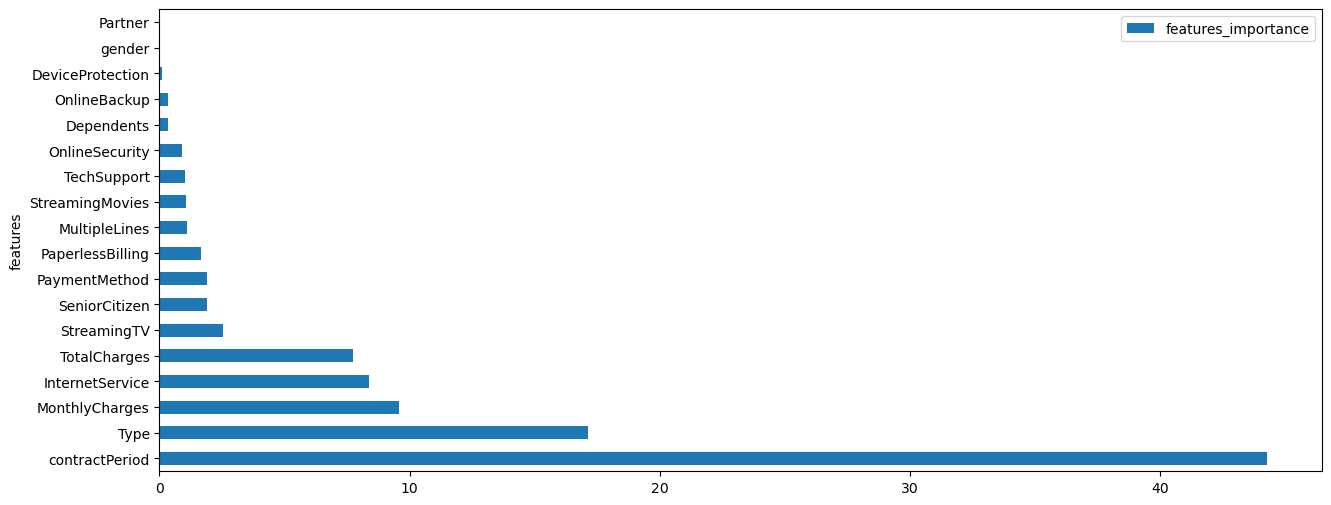

In [67]:
cbc_feature_importances = pd.DataFrame({'features':features_train.columns,
                                   'features_importance':cbc_model.feature_importances_}).sort_values(
    'features_importance', ascending=False)
cbc_feature_importances.set_index('features').plot(kind='barh', figsize=(15,6))
plt.show()

In [68]:
cbc_features = features.drop(['DeviceProtection', 'Partner','gender'], axis = 1) 
cbc_features_train, cbc_features_test, cbc_target_train, cbc_target_test = split_data(cbc_features, target)

In [69]:
cbc_fi = CatBoostClassifier()
parameters = {'depth' : [4, 5, 6, 7, 8, 9, 10],
             'learning_rate': [0.05, 0.1, 0.5, 1],
             'iterations': [1, 5, 10, 15, 20, 25, 30]}
Grid_cbc_fi = GridSearchCV(estimator = cbc_fi, param_grid = parameters, scoring = 'roc_auc', cv = 5, n_jobs = -1)
Grid_cbc_fi.fit(cbc_features_train, cbc_target_train, logging_level='Silent')

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_cbc_fi.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_cbc_fi.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_cbc_fi.best_params_)

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8876662598473161

 The best parameters across ALL searched params:
 {'depth': 4, 'iterations': 30, 'learning_rate': 1}


/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [70]:
cbc_model_fi = CatBoostClassifier(**Grid_cbc_fi.best_params_)
cbc_model_fi.fit(cbc_features_train, cbc_target_train)
probabilities_cbc_test_fi = cbc_model_fi.predict_proba(cbc_features_test)
cbc_model_one_test_fi = probabilities_cbc_test_fi[:,1]

cbc_roc_auc_fi = roc_auc_score(cbc_target_test, cbc_model_one_test_fi)
print(cbc_roc_auc_fi)

0:	learn: 0.4567942	total: 1.64ms	remaining: 47.7ms
1:	learn: 0.4199162	total: 2.96ms	remaining: 41.4ms
2:	learn: 0.3991105	total: 4.08ms	remaining: 36.7ms
3:	learn: 0.3939088	total: 5.71ms	remaining: 37.1ms
4:	learn: 0.3903070	total: 6.64ms	remaining: 33.2ms
5:	learn: 0.3865061	total: 7.63ms	remaining: 30.5ms
6:	learn: 0.3842556	total: 8.58ms	remaining: 28.2ms
7:	learn: 0.3796148	total: 9.52ms	remaining: 26.2ms
8:	learn: 0.3755269	total: 10.5ms	remaining: 24.6ms
9:	learn: 0.3703556	total: 11.7ms	remaining: 23.3ms
10:	learn: 0.3673572	total: 12.9ms	remaining: 22.3ms
11:	learn: 0.3590857	total: 14.2ms	remaining: 21.3ms
12:	learn: 0.3563061	total: 15.4ms	remaining: 20.1ms
13:	learn: 0.3487791	total: 17ms	remaining: 19.4ms
14:	learn: 0.3474975	total: 18ms	remaining: 18ms
15:	learn: 0.3445013	total: 18.9ms	remaining: 16.5ms
16:	learn: 0.3398966	total: 19.8ms	remaining: 15.1ms
17:	learn: 0.3334622	total: 20.7ms	remaining: 13.8ms
18:	learn: 0.3300851	total: 21.6ms	remaining: 12.5ms
19:	learn

Following the elimination of less important parameters, the **CatBoostClassifier model gave the highest value of the roc metric-auc = 0.9**

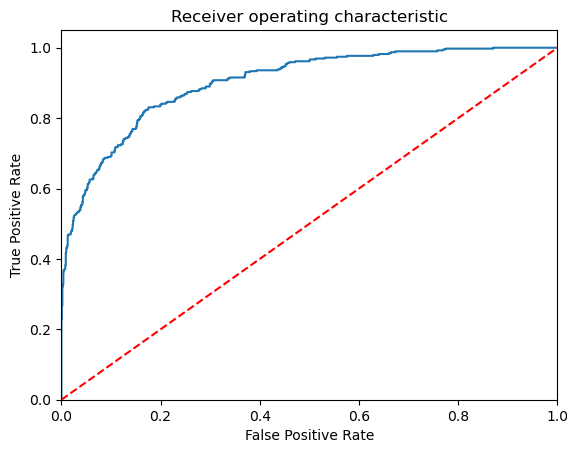

In [71]:
cbc_roc_auc_curve = roc_auc_score(cbc_target_test, cbc_model_fi.predict(cbc_features_test))
fpr, tpr, thresholds = roc_curve(cbc_target_test, cbc_model_fi.predict_proba(cbc_features_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='CatBoostClassifier (area = %0.2f)' % cbc_roc_auc_curve)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.savefig('Log_ROC')
plt.show()

### Final report

#### Research Description

___
___
From  telecom operator received a request for a model that could predict the outflow of customers in order to minimize it. If it turns out that the user is planning to leave, he may be offered promo codes and special conditions for retention.

The operator's team collected personal data about some customers, information about their tariffs and contracts.

**Data description**:
The data consists of files received from different sources:

- contract.csv — information about the contract;
- personal.csv — personal data of clients;
- internet.csv — information about Internet services;
- phone.csv — information about telephony services.


In all files, the CustomerID column contains a unique customer code.
Information about the contracts is current as of February 1, 2020.

**The target metric of the accuracy of the model according to the customer's conditions **- ROC-AUC is not lower than 0.75.

#### Description of the received source data

The customer transferred user data in 4 different files to build models.
___

The first file with information about contracts concluded with customers (*contract*) contained 7043 unique lines, which is equivalent to 7043 unique customers. The table contains data:

- The beginning and end of the term of the contract with the client;
- Type of payment under the contract (monthly, annual);
- Use of non-cash payments;
- Payment method;
- Monthly and general expenses for services.

When studying the monthly costs, it was found that most of the customers used the minimum cost tariff. The total cost of most customers in this regard was small. Also, the low total costs of most customers were explained by the recent connection to the operator's services.

<div>
<img src="https://i.postimg.cc/4NNB6fFN/1.png" width="1000"/>
</div>

___
The file with the name *personal* contains personal information about customers. There are also 7043 rows with corresponding unique numbers in the data. In addition, the table contains information about:

- customer field;
- having of retirement status by age;
- having of a spouse;
- having dependents.
___
Further, the file called *internet* contained information about the use of services by clients on the Internet, including:

- Type of connection;
- internet security: antivirus;
- blocking unsafe sites;
- Dedicated technical support line;
- Cloud file storage for data backup;
- Streaming TV and movie catalog.

This table contained 5,517 rows, which meant that only 78% of all customers used the company's internet services during the period under review.
___

The *phone* database also represented a smaller number of customers - 6361 unique users. Thus, the share of the company's customers using telephone services was about 90%, which exceeds the share of customers using the company's internet services by 12%. At the same time, it should be understood that some customers are included in both samples and use both telephony services and the company's internet services.

In the *phone* database, in addition to the unique number of the client, there is an information on whether he has the ability to conduct parallel lines during a call.
___
___

#### Description of errors and inaccuracies in the data

___
___
The greatest amount of necessary preprocessing actions was required when working with data on existing contracts (*contract*):

- all columns except MonthlyCharges had the object format, including a column with numerical data *TotalCharges* and columns with dates
- there were "No" values in the EndDate column, which meant that the contract was valid on February 1, 2020.
- also, there were only 4 unique dates in the EndDate column. Probably the operator updated the status of contracts on these dates.
- there were no values in the *TotalCharges* column for some users. They were characterized by the start date of the contract in February 2020, that is, at the time of the database formation date. Thus, they did not have time to incur costs, but it was advisable to replace the missing values with 0 in the future in order to avoid errors.
- there was no target attribute in the file on contracts with clients confirming the fact that the client left the operator. Thus, it was necessary to take the end date of the contract with the client as this sign. The absence of an end date for the contract meant that the client did not leave.
- about a quarter of the customers had an contract expiration date, which meant that the data was unbalanced;
- no hidden duplicates or outliers (outliers) were found in the file.

In other source files (*personal*,*internet*,*phone*) containing exclusively categorical features, there were also no missing values, hidden duplicates. The only point that requires special attention in further work is the different number of lines in different files, which, if careless, can lead to data loss.

___
___

#### Description of the actions performed with the data

___
___

At this stage, actions were taken to eliminate deficiencies in the file with information about contracts identified at the previous stage:
- - The format of the column *TotalCharges* has been changed to numeric, the columns *BeginDate* and *EndDate* to date format;
- The "No" values in the *EndDate* column have been replaced with the data slice date - 2020-02-01;
- In the *TotalCharges* column, the missing values for new customers have been replaced with zero values;
___
___

#### Description of the actions performed to build the model

Having eliminated the inaccuracies and inconsistencies found in the data, as the next stage actions aimed at creating conditions for building forecasting models were carried out.

- First of all, data from different files were joined into one dataset. The merge was performed using the **merge** method with the *how='outer' parameter to avoid data loss. After each merge, the total size of the merged table was checked.


- The next and most important of these actions was the creation of a target variable, since it was initially absent explicitly. As previously determined, the target variable was created from the *EndDate* column - the expiration date of the contract with the client. Thus, the binary attribute (1,0) was created according to the following logic:
> If there is any date other than 2020-02-01 in the *EndDate* column of the *contracts* file (the database formation date added manually at the data processing stage), the attribute was equal to 1 ("the client has left"). If the date was equal to 2020-02-01, the attribute was equal to 0 ("the client did not leave").

- It was decided to extract the *contractPeriod* parameter from the columns with the start date of the contract and its end (*BeginDate*, *EndDate*), which indicated the duration of the contract and was calculated as the difference between the start and end dates in days.


- Further, the columns with the start date of the contract and the end date of the contract were deleted, since the necessary features were extracted from them, and these columns themselves could lead to data leakage during training.
- The CustomerID column was unique for each customer, including future customers. Therefore, it could not influence the target attribute. It was decided that it could be deleted.

- Part of the data in the combined dataset was represented by categorical variables:
> ('Type','PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner','Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines')

These features for further training of models were encoded into a numerical format using the Ordinal Encoder.


- To study the correlation of data, a correlation matrix was constructed, which showed that the columns with the numerical data contractPeriod and TotalCharges had the least correlation with the target variable.

<div>
<img src="https://i.postimg.cc/44w1xCNC/2022-08-19-01-07-57.png" width="500"/>
</div>

___
After performing these actions, the resulting dataset was divided into training and test samples. **The size of the test sample was 20%.**
Immediately after the separation of the sample, the Standard Scale tool was used to bring the numerical data to the same order.
___

After the actions carried out, 3 different types of forecasting models were build:
- **LogisticRegression**
- **RandomForest**
- **CatboostClassifier**

When building each of the models, cross-validation was used.
___

**LogisticRegression**

For the Logistic Regression model, a check for the presence of multicollinarity was also carried out beforehand, according to the results of which features ('contractPeriod', 'MonthlyCharges', 'TotalCharges') were excluded for this model.


Based on the results of the performed actions **Logistic regression showed the accuracy of the target indicator ROC-AUC in the test sample - 0.81**
___

**RandomForest**

****This model showed the accuracy of the target indicator ROC-AUC in the test sample - 0.87**
The study of the importance of the parameters showed that the columns contractPeriod, Type, MonthlyCharges, TotalCharges, InternetService have the greatest influence. It was decided to remove the remaining columns and retrain the model again. The performed actions did not lead to an increase in the accuracy of the prediction of the model - ROC-AUC remained equal to - 0.87.
___

**Catboost**

The Catboost model gave a forecast with the accuracy of the target indicator ROC-AUC on the test sample - 0.89. A similar study of the importance of parameters showed that the columns *'DeviceProtection', 'Partner','gender'* have the least influence. After deleting these columns and retraining **, the prediction accuracy of the CatBoostClassifier model by the ROC-AUC metric increased to 0.90.**
___

#### Argumentation of the choice of the final model

|№      |     Модель     |     ROC-AUC on test sample     |
|:-----|:----:|----:|
|1 |LogisticRegression |0,81 |
|2 |RandomForest |0,87 |
|3 |CatboostRegression |0,9 |

According to the results of the comparison, it can be seen that CatBoostClassifier gives the highest accuracy. Therefore, it is worth choosing it for the final recommendation.

#### Summary of the work done, recommendations to the customer for further work with the model.

At the request of the customer, data for predicting potentially lost customers was studied and worked out.
Based on the processed data, the dependencies between them were studied and potentially important calculated indicators were added.
Based on the received dataframe, 3 different prediction models were built. The models showed significantly different accuracy of the target metric. The most accurate result was given by the CatboostClassifier model. The accuracy of the forecast for a given target metric exceeds the maximum mark of the accuracy desired by the customer, and therefore the business is recommended to use this model on real relevant data.